In [1]:
import pandas as p
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.config.experimental.list_physical_devices('GPU'))

In [2]:
%store -r data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   target      1600000 non-null  int64 
 1   ids         1600000 non-null  int64 
 2   date        1600000 non-null  object
 3   flag        1600000 non-null  object
 4   user        1600000 non-null  object
 5   text        1600000 non-null  object
 6   clean_text  1600000 non-null  object
dtypes: int64(2), object(5)
memory usage: 85.4+ MB


In [3]:
X = data['clean_text'].values
y = data['target'].values
y = np.array([i if i == 0 else 1 for i in y])
print(len(X))
print(len(y))

1600000
1600000


In [4]:
X_train, X_validation_test, y_train, y_validation_test = train_test_split(X, y, test_size=0.02, random_state=0)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation_test, y_validation_test, test_size=0.5, random_state=0)
print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)
np.unique(y_train, return_counts=True)

(1568000,) (1568000,) (16000,) (16000,) (16000,) (16000,)


(array([0, 1], dtype=int64), array([783999, 784001], dtype=int64))

In [6]:
words = [word for doc in X_train for word in doc.split()]
print(len(words))

18175435


In [5]:
vectorizer = TfidfVectorizer(encoding='latin-1')
vec = vectorizer.fit_transform(X_train.astype(str))
vocab_size = vec.shape[1]
embedding_dim = 200
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [6]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding=padding_type)
print(len(train_sequences), train_padded.shape)

validation_sequences = tokenizer.texts_to_sequences(X_validation)
validation_padded = tf.keras.preprocessing.sequence.pad_sequences(validation_sequences, padding=padding_type, maxlen=train_padded.shape[1])
print(len(validation_sequences), validation_padded.shape)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding=padding_type, maxlen=train_padded.shape[1])
print(len(test_sequences), test_padded.shape)

training_label_seq = np.array(y_train)
validation_label_seq = np.array(y_validation)
test_label_seq = np.array(y_test)
print(training_label_seq.shape, validation_label_seq.shape, test_label_seq.shape)
print(np.unique(training_label_seq, return_counts=True), np.unique(validation_label_seq, return_counts=True), np.unique(test_label_seq, return_counts=True))

1568000 (1568000, 40)
16000 (16000, 40)
(1568000,) (16000,)
(array([0, 1], dtype=int64), array([783999, 784001], dtype=int64)) (array([0, 1], dtype=int64), array([7933, 8067], dtype=int64))


In [7]:
# compile model
keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 200)           48437000  
_________________________________________________________________
bidirectional (Bidirectional (No

In [8]:
# train model
num_epochs = 2
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq))

Train on 1568000 samples, validate on 16000 samples
Epoch 1/2
1568000/1568000 [==============================] - 16020s 10ms/sample - loss: 0.4006 - acc: 0.8172 - val_loss: 0.3790 - val_acc: 0.8301
Epoch 2/2
1568000/1568000 [==============================] - 21099s 13ms/sample - loss: 0.3325 - acc: 0.8550 - val_loss: 0.3986 - val_acc: 0.8202


In [7]:
def plot_graphs(history, string):
  plt.plot(range(1, len(history.history[string])+1), history.history[string])
  plt.plot(range(1, len(history.history['val_'+string])+1), history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [ ]:
def save_model(model, name):
    model_json = model.to_json()
    with open(name + '.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights(name + '.h5')
    print('Saved model to disk')

In [ ]:
def load_model(name):
    json_file = open(name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)
    loaded_model.load_weights(name + '.h5')
    print('Loaded model from disk')
    return loaded_model

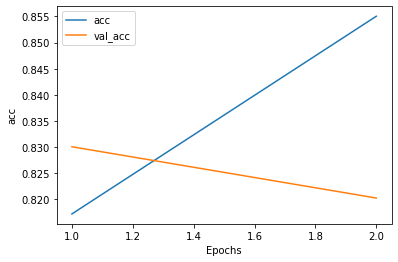

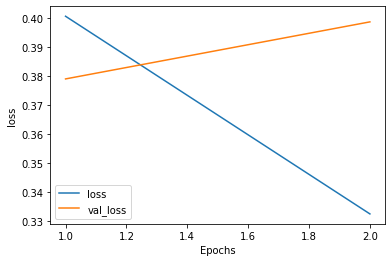

In [11]:
# plot model
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [12]:
# evaluate model
scores = model.evaluate(test_padded, test_label_seq)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

16000/16000 [==============================] - 49s 3ms/sample - loss: 0.4019 - acc: 0.8216
acc: 82.16%


In [13]:
# save model
save_model(model, 'modelLstm2')

Saved model to disk


In [ ]:
# load model
loaded_model = load_model('modelLstm2')

# evalaute loaded model on test data
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evalaute(test_padded, test_label_seq)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [8]:
# compile model
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model2.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 200)           48437000  
_________________________________________________________________
bidirectional (Bidirectional (No

In [9]:
# train model
num_epochs = 2
history2 = model2.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq))

Train on 1568000 samples, validate on 16000 samples
Epoch 1/2
1568000/1568000 [==============================] - 21076s 13ms/sample - loss: 0.4015 - acc: 0.8168 - val_loss: 0.3789 - val_acc: 0.8275
Epoch 2/2
1568000/1568000 [==============================] - 16179s 10ms/sample - loss: 0.3327 - acc: 0.8550 - val_loss: 0.4093 - val_acc: 0.8202


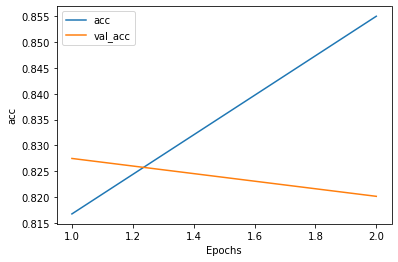

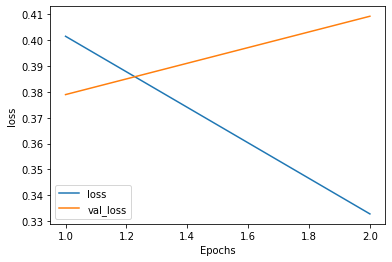

In [10]:
# plot model
plot_graphs(history2, "acc")
plot_graphs(history2, "loss")

In [11]:
# evaluate model
scores2 = model2.evaluate(test_padded, test_label_seq)
print("%s: %.2f%%" % (model2.metrics_names[1], scores2[1]*100))

16000/16000 [==============================] - 48s 3ms/sample - loss: 0.4118 - acc: 0.8199
acc: 81.99%


In [12]:
# save model
save_model(model2, 'model2Lstm2')

Saved model to disk


In [ ]:
# load model
loaded_model = load_model('model2Lstm2')

# evalaute loaded model on test data
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evalaute(test_padded, test_label_seq)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [49]:
import io

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

(17082, 100)
